In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import os
import glob
import sys


current_dir = os.getcwd()
# Get the grandparent directory (two levels up)
grandparent_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
# Add the grandparent directory to sys.path
sys.path.insert(0, grandparent_dir)

from utility import Plume2D_dataloader
from viz import show_generated_samples

/home1/junjieyu/.conda/envs/DDPM/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home1/junjieyu/.conda/envs/DDPM/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## repaint

In [5]:
from diffusers import RePaintPipeline, RePaintScheduler
generator = torch.Generator(device="cuda").manual_seed(0)\

# Create the network
net = UNet2DModel(
    sample_size=(20,68),  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

# Load the model
model_path = '/scratch1/junjieyu/Diffusion_Model/DDPM/CO2_PLUME_examples/monitor/model_80.pt'
net.load_state_dict(torch.load(model_path))

# load dataset
train_dataloader = Plume2D_dataloader(batch_size = 16)

/home1/junjieyu/.conda/envs/DDPM/lib/python3.12/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
repaint_scheduler = RePaintScheduler()
repaint_pipe = RePaintPipeline(net, scheduler=repaint_scheduler)
repaint_pipe = repaint_pipe.to("cuda")


  0%|          | 0/1720 [00:00<?, ?it/s]

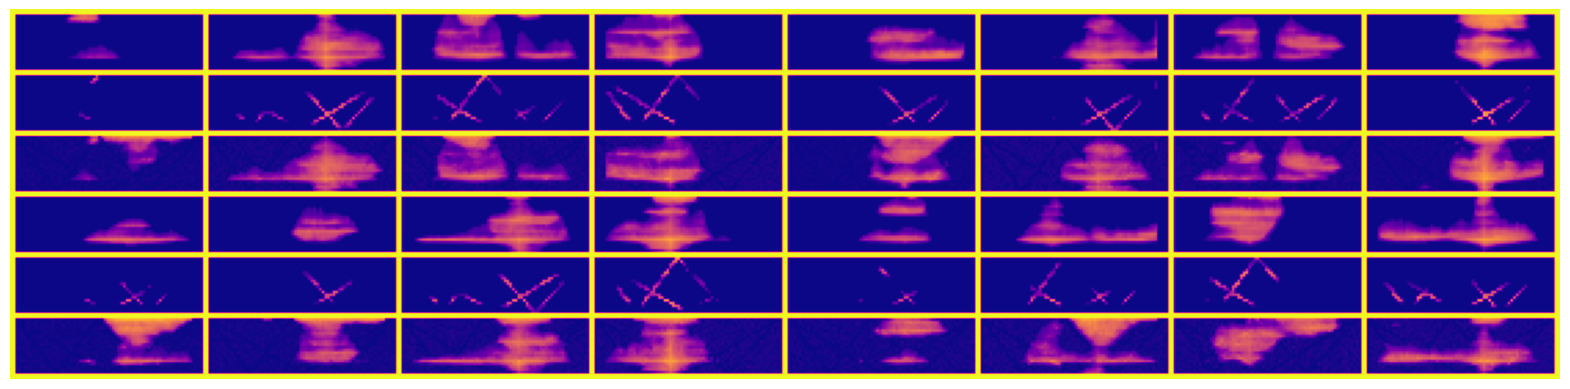

In [23]:
from utility import get_penetrate_mask, get_random_pixel_mask
bs = 16
# create a batch of mask
shape = (1,68,20)
receivers = [(0,i*30,20) for i in range(2)]
senders = [(0,0,20),(1,67,20)]
batch_mask = torch.zeros((bs,1,20,68))
for i in range(bs):
    mask = get_penetrate_mask(senders, receivers, shape = shape)
    batch_mask[i] = mask
batch_mask = batch_mask.to(device)

sample = next(iter(train_dataloader))
sample = sample.to(device)
repaint_images = repaint_pipe(
            image=sample,
            mask_image=batch_mask,
            num_inference_steps=100,
            eta=0,
            jump_length=10,
            jump_n_sample=10,
            generator=generator,
            output_type = 'numpy'
            ).images

repaint_images = torch.tensor(repaint_images)
repaint_images = repaint_images * 2 -1
from viz import show_conditional_generation, compare_repaint
compare_repaint(repaint_images, sample, batch_mask, 
                    binary = False,
                    save_fig_name ='repaint_comparison.png')
# conditional_images = sample * batch_mask
# show_conditional_generation(conditional_images.cpu(), repaint_images.cpu(), ncols=8)

## Comprehensive uncertainty quantification

In [24]:
from utility import get_penetrate_mask, get_random_pixel_mask

shape = (1,68,20)
receivers_collect = [[(0,i*30,20) for i in range(2)],
                        [(0,i*20,20) for i in range(3)],
                        [(0,i*10,20) for i in range(6)]]
senders = [(0,0,20),(1,67,20)]
# creata a folder to save the images
save_dir = '/scratch1/junjieyu/Diffusion_Model/DDPM/CO2_PLUME_examples/Plume_UQ'

import os
import shutil
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    shutil.rmtree(save_dir)
    os.makedirs(save_dir)

for ri, receivers in enumerate(receivers_collect):
    for c in range(5):
        unique_sample = next(iter(train_dataloader))
        unique_sample = unique_sample[0].to(device)

        # repeat the unique sample to create a batch
        bs = 16
        sample = unique_sample.unsqueeze(0).repeat(bs,1,1,1)
        # create a batch of mask
        batch_mask = torch.zeros((bs,1,20,68))
        for i in range(bs):
            mask = get_penetrate_mask(senders, receivers, shape = shape)
            batch_mask[i] = mask
        batch_mask = batch_mask.to(device)

        repaint_images = repaint_pipe(
                    image=sample,
                    mask_image=batch_mask,
                    num_inference_steps=100,
                    eta=0,
                    jump_length=10,
                    jump_n_sample=10,
                    generator=generator,
                    output_type = 'numpy'
                    ).images

        repaint_images = torch.tensor(repaint_images)
        # repaint_images = repaint_images * 2 -1


        # show original, mean and variance of the repaint images
        # also show several samples
        mean = repaint_images.mean(dim = 0)
        var = repaint_images.var(dim = 0)
        
        fig, axes = plt.subplots(4,3, figsize = (15,8))
        axes[0,0].imshow(sample[0,0].cpu() * 0.5 + 0.5, cmap = 'plasma',vmin = 0, vmax=1)
        axes[0,0].set_title('Original')
        axes[0,1].imshow(mean, cmap = 'plasma',vmin = 0, vmax=1)
        axes[0,1].set_title('Generation-Mean')
        axes[0,2].imshow(var, cmap = 'YlGn')
        axes[0,2].set_title('Generation-Variance')

        for i in range(1,4):
            for j in range(3):
                axes[i,j].imshow(repaint_images[(i-1)*3+j].cpu(), cmap = 'plasma')
                axes[i,j].set_title(f'Sample {(i-1)*3+j+1}')
        plt.tight_layout()

        # remove the label
        for ax in axes.flatten():
            ax.axis('off')
        
        # save the figure
        fig_name = f'{save_dir}/reconstruct_reveivers_{ri}_case_{c}.png'

        # close the figure
        plt.savefig(fig_name)
        plt.close()


  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/1720 [00:00<?, ?it/s]

torch.Size([16, 1, 20, 68])